# Influence of dependent variable (y)’s scale on AIC, BIC

[Read the full blog here](https://miaowang-datascience.medium.com/influence-of-dependent-variable-y-s-scale-on-aic-bic-fff3fe6d6b52)


In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm # get OLS's summary
from patsy import dmatrices # create design matrix in formula like string

import matplotlib.pyplot as plt 
import seaborn as sns

import re

In [2]:
### simulation setting ###
N = 10000 # total observations
N_FEATURES = 9
SEED = 1 # seed for random generater
COEF = [2, 2, 10, 100] + [0] * (N_FEATURES - 4) # coef in front of X1, X2, .., X9

### simulate dataset

$$X_{ij} \sim Gamma(1,2)$$
$$e_j \sim Normal(0,1)$$
$$y_j = e_j + 2*X_{1j} + 2*X_{2j} + 10*X_{3j} + 100*X_{4j}$$


where $i = 1, ..., N, j = 1, ..., N\_FEATURES$

In [3]:
np.random.seed(SEED)

In [4]:
E = np.random.normal(0, 1, size = N) #

In [5]:
# X1, ..., X9 (iid) ~ Gamma(1, 2)

X = [np.random.gamma(scale = 1, shape = 2, size = N_FEATURES) for i in range(N)]
X = pd.DataFrame(X)
X.columns = [f'X{i}' for i in range(1,N_FEATURES+1)]

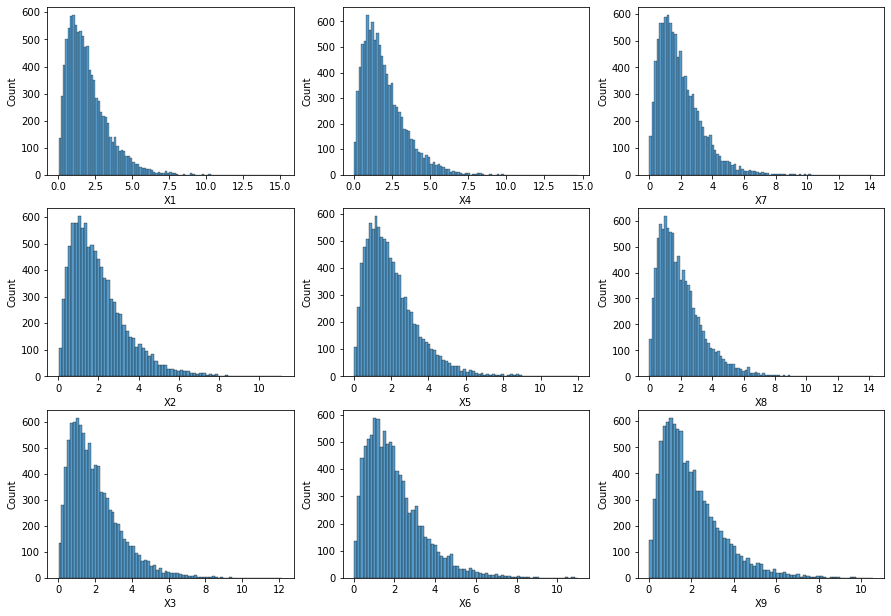

In [6]:
# first 9 Xs
fig, ax = plt.subplots(3,3, figsize = (3*5,3*3.5))
ax_x, ax_y = np.meshgrid(range(3), range(3))

for i in range(9):
    ix = ax_x.flatten()[i]
    iy = ax_y.flatten()[i]
    sns.histplot(X[f'X{i+1}'], ax = ax[ix, iy])
    ax[ix, iy].set(xlabel=f'X{i+1}')

plt.show()

In [7]:
# y ~ 2*X1 + 2*X2 + 10*X3 + 100*X4 + e, e ~ N(0,1)
y = X.apply(lambda x: sum(x*COEF), axis = 1) + E

In [8]:
# simulated dataset
df = pd.concat([pd.DataFrame({'y':y}), X], axis = 1)

In [9]:
df

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9
0,211.627500,1.513501,1.978927,1.351813,1.895002,1.302780,2.440241,1.069008,0.832217,1.607810
1,272.221906,1.954914,2.347070,2.917433,2.350554,3.107972,4.499650,0.258985,1.867754,3.446474
2,48.147814,0.807056,1.148177,1.678202,0.279835,0.748604,2.912387,0.633678,1.006170,0.994551
3,152.671457,4.397001,2.062764,0.337850,1.374464,2.217312,3.068843,1.260498,0.581203,0.616214
4,377.842627,0.752648,1.018980,0.746929,3.659647,1.137868,1.642715,1.008213,1.609423,3.454431
...,...,...,...,...,...,...,...,...,...,...
9995,77.450903,0.696612,0.555907,0.891392,0.659590,1.073479,0.293468,5.362283,0.643110,1.119759
9996,132.180628,2.270307,4.801280,2.837240,0.891760,1.890017,0.488463,1.189510,3.344813,2.322799
9997,189.478302,3.119588,2.202116,4.902557,1.308235,3.555218,0.355613,2.929900,0.827681,3.048444
9998,111.813996,0.153932,2.222002,0.713673,0.999881,1.338999,1.762219,1.313008,1.173354,2.793055


### Consider 2 different featureset

$$z_j \sim X_{1j} + X_{5j} + X_{6j} + X_{7j} + X_{8j} + X_{9j} \ (1)$$
$$z_j \sim X_{5j} + X_{6j} + X_{7j} + X_{8j} + X_{9j} \ (2)$$

Assume we get a dataset of $(w_j, x_{1j}, ..., x_{9j})$:
- Scenario 1: $w_j = y_j$
- Scenario 2: $w_j = (y_j)^4$

In [10]:
# create 2 different features sets

def subset_metric_compare(y_transform = 'y'):
    
    y1, X1 = dmatrices(y_transform + ' ~ X1 + X5 + X6 + X7 + X8 + X9', data=df, return_type='dataframe')       # choice 1
    y2, X2 = dmatrices(y_transform + ' ~ X5 + X6 + X7 + X8 + X9', data=df, return_type='dataframe')       # choice 2

    # compare AIC, BIC
    mod1 = sm.OLS(y1, X1).fit() 
    mod2 = sm.OLS(y2, X2).fit() 

    result = pd.DataFrame({'Loglik':[mod1.llf, mod2.llf], 
                           'AIC':[mod1.aic, mod2.aic], 
                           'BIC':[mod1.bic, mod2.bic]}, 
                          
                          index = ['mod1: w ~ X1 + X5 + X6 + X7 + X8 + X9', 
                                   'mod2: w ~ X5 + X6 + X7 + X8 + X9'])
    
    print('w = ' + y_transform)
    message = f"min AIC belongs to {result['AIC'].idxmin()} ({result['AIC'].min()})"
    print(re.split(':', message)[0])
    
    return result.round(2) 

In [11]:
subset_metric_compare() # original scale

w = y
min AIC belongs to mod1


,Loglik,AIC,BIC
mod1: w ~ X1 + X5 + X6 + X7 + X8 + X9,-63770.34,127554.68,127605.15
mod2: w ~ X5 + X6 + X7 + X8 + X9,-63774.29,127560.59,127603.85


In [12]:
subset_metric_compare('np.power(y,4)') # quaduple scale

w = np.power(y,4)
min AIC belongs to mod2


,Loglik,AIC,BIC
mod1: w ~ X1 + X5 + X6 + X7 + X8 + X9,-265594.73,531203.45,531253.92
mod2: w ~ X5 + X6 + X7 + X8 + X9,-265595.47,531202.95,531246.21


### understand when exactly does the power on y flip the model choice

Assume: $w_j = (y_j)^p$

We want to know how large does $p$ needs to be, when AIC prefer the model 2 (which is the wrong choice)

In [13]:
def get_aic(power_range, df = df):
    
    result = pd.DataFrame()
    
    for power in power_range:
    
        y1, X1 = dmatrices('np.power(y,' +  str(power) + ') ~ X1 + X5 + X6 + X7 + X8 + X9', data=df, return_type='dataframe')       # choice 1
        y2, X2 = dmatrices('np.power(y,' +  str(power) + ') ~ X5 + X6 + X7 + X8 + X9', data=df, return_type='dataframe')       # choice 2

        # compare AIC, BIC
        mod1 = sm.OLS(y1, X1).fit() 
        mod2 = sm.OLS(y2, X2).fit() 

        r = pd.DataFrame({'power':[power], 'model1-AIC':[mod1.aic], 'model2-AIC':[mod2.aic]})
        
        result = result.append(r, ignore_index=True)
        result['model1-AIC < model2-AIC'] = result['model1-AIC'] < result['model2-AIC']
        
    return result

In [14]:
result = get_aic(np.arange(3,4,0.1))

In [15]:
result 

# when w_j = (y_j)^p, p >= 3.5, AIC of the model 2 wins

,power,model1-AIC,model2-AIC,model1-AIC < model2-AIC
0,3.0,392503.101648,392503.626393,True
1,3.1,406146.064566,406146.460173,True
2,3.2,419842.168066,419842.441400,True
3,3.3,433590.955123,433591.112551,True
4,3.4,447391.617798,447391.665264,True
5,3.5,461243.024464,461242.967552,False
6,3.6,475143.752782,475143.596770,False
7,3.7,489092.127391,489091.877297,False
8,3.8,503086.260936,503085.921554,False
9,3.9,517124.096851,517123.672774,False


### what if the effect of X1 on y is 5 times stronger? 

How big does $p$ needs to be?

In [16]:
def coef_X1(coef1, power_range):
    coef_new = COEF
    coef_new[0] = coef1
    y = X.apply(lambda x: sum(x*coef_new), axis = 1) + E
    
    df = pd.concat([pd.DataFrame({'y':y}), X], axis = 1)
    
    r = get_aic(power_range, df)
    r['coef1'] = coef1
    
    return r

In [17]:
coef_X1(10, np.arange(1, 10, 1))

# when w_j = (y_j)^p, p >= 7, AIC of the model 2 wins
# in another words, since the effect of X1 on y is larger, AIC is more robust to larger scale of w

,power,model1-AIC,model2-AIC,model1-AIC < model2-AIC,coef1
0,1,1.275547e+05,1.276676e+05,True,10
1,2,2.596736e+05,2.597307e+05,True,10
2,3,3.937265e+05,3.937513e+05,True,10
3,4,5.325799e+05,5.325888e+05,True,10
4,5,6.752932e+05,6.752957e+05,True,10
5,6,8.199671e+05,8.199673e+05,True,10
6,7,9.654452e+05,9.654446e+05,False,10
7,8,1.111240e+06,1.111239e+06,False,10
8,9,1.257164e+06,1.257163e+06,False,10


### genralization 

coef1 = relationship between effect of X1 on y ($\beta_1$)

p = the minmum power on y when AIC picks the wrong model (recall $w_j = y_j^p$)

In [18]:
result = pd.DataFrame()

for coef1 in range(0, 25, 2):
    r = coef_X1(coef1, np.arange(1, 10, 1))
    
    result = result.append(r, ignore_index = True)

In [19]:
result[result['model1-AIC < model2-AIC'] == False].\
groupby('coef1').head(1).loc[:, ['coef1', 'power']].\
rename(columns = {'power':'min of power that AIC picks model 2'})

,coef1,min of power that AIC picks model 2
0,0,1
12,2,4
22,4,5
32,6,6
41,8,6
51,10,7
60,12,7
70,14,8
79,16,8
89,18,9
